파일 import

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


DATA_FILE_NAME='train.tsv'


In [67]:
df = pd.read_csv(DATA_FILE_NAME, delimiter='\t')

In [68]:
effective_len = len(df.loc[df['가성비'] > 0])
clean_len = len(df.loc[df['청결'] > 0])
tasty_len = len(df.loc[df['맛'] > 0])
vibe_len = len(df.loc[df['분위기'] > 0])
kind_len = len(df.loc[df['친절'] > 0])

[79, 92, 457, 251, 182]


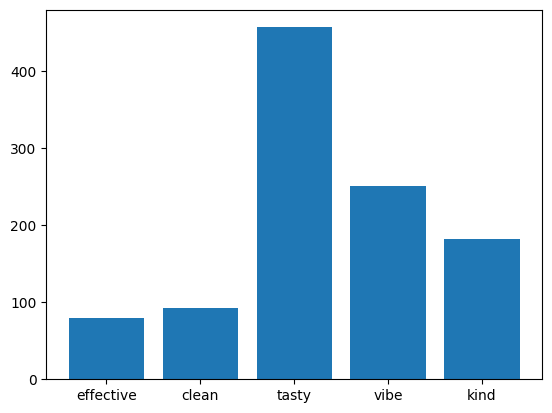

In [69]:
x = np.arange(5)
LABEL_COLUMNS = ['effective', 'clean', 'tasty', 'vibe', 'kind']
values = [effective_len, clean_len, tasty_len, vibe_len, kind_len]


plt.bar(x, values)
plt.xticks(x, LABEL_COLUMNS)

print(values)
plt.show()
# 데이터가 굉장히 불균형 보강 작업이 필요한거 같음

In [70]:
import random
import pickle
import re

wordnet = {}
with open("wordnet.pickle", "rb") as f:
	wordnet = pickle.load(f)


# 한글만 남기고 나머지는 삭제
def get_only_hangul(line):
	parseText= re.compile('/ ^[ㄱ-ㅎㅏ-ㅣ가-힣]*$/').sub('',line)

	return parseText



########################################################################
# Synonym replacement
# Replace n words in the sentence with synonyms from wordnet
########################################################################
def synonym_replacement(words, n):
	new_words = words.copy()
	random_word_list = list(set([word for word in words]))
	random.shuffle(random_word_list)
	num_replaced = 0
	for random_word in random_word_list:
		synonyms = get_synonyms(random_word)
		if len(synonyms) >= 1:
			synonym = random.choice(list(synonyms))
			new_words = [synonym if word == random_word else word for word in new_words]
			num_replaced += 1
		if num_replaced >= n:
			break

	if len(new_words) != 0:
		sentence = ' '.join(new_words)
		new_words = sentence.split(" ")

	else:
		new_words = ""

	return new_words


def get_synonyms(word):
	synomyms = []

	try:
		for syn in wordnet[word]:
			for s in syn:
				synomyms.append(s)
	except:
		pass

	return synomyms

########################################################################
# Random deletion
# Randomly delete words from the sentence with probability p
########################################################################
def random_deletion(words, p):
	if len(words) == 1:
		return words

	new_words = []
	for word in words:
		r = random.uniform(0, 1)
		if r > p:
			new_words.append(word)

	if len(new_words) == 0:
		rand_int = random.randint(0, len(words)-1)
		return [words[rand_int]]

	return new_words

########################################################################
# Random swap
# Randomly swap two words in the sentence n times
########################################################################
def random_swap(words, n):
	new_words = words.copy()
	for _ in range(n):
		new_words = swap_word(new_words)

	return new_words

def swap_word(new_words):
	random_idx_1 = random.randint(0, len(new_words)-1)
	random_idx_2 = random_idx_1
	counter = 0

	while random_idx_2 == random_idx_1:
		random_idx_2 = random.randint(0, len(new_words)-1)
		counter += 1
		if counter > 3:
			return new_words

	new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1]
	return new_words

########################################################################
# Random insertion
# Randomly insert n words into the sentence
########################################################################
def random_insertion(words, n):
	new_words = words.copy()
	for _ in range(n):
		add_word(new_words)
	
	return new_words


def add_word(new_words):
	synonyms = []
	counter = 0
	while len(synonyms) < 1:
		if len(new_words) >= 1:
			random_word = new_words[random.randint(0, len(new_words)-1)]
			synonyms = get_synonyms(random_word)
			counter += 1
		else:
			random_word = ""

		if counter >= 10:
			return
		
	random_synonym = synonyms[0]
	random_idx = random.randint(0, len(new_words)-1)
	new_words.insert(random_idx, random_synonym)



def EDA(sentence, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=9):
	sentence = get_only_hangul(sentence)
	words = sentence.split(' ')
	words = [word for word in words if word is not ""]
	num_words = len(words)

	augmented_sentences = []
	num_new_per_technique = int(num_aug/4) + 1

	n_sr = max(1, int(alpha_sr*num_words))
	n_ri = max(1, int(alpha_ri*num_words))
	n_rs = max(1, int(alpha_rs*num_words))

	# sr
	for _ in range(num_new_per_technique):
		a_words = synonym_replacement(words, n_sr)
		augmented_sentences.append(' '.join(a_words))

	# ri
	for _ in range(num_new_per_technique):
		a_words = random_insertion(words, n_ri)
		augmented_sentences.append(' '.join(a_words))

	# rs
	for _ in range(num_new_per_technique):
		a_words = random_swap(words, n_rs)
		augmented_sentences.append(" ".join(a_words))

	# rd
	for _ in range(num_new_per_technique):
		a_words = random_deletion(words, p_rd)
		augmented_sentences.append(" ".join(a_words))

	augmented_sentences = [get_only_hangul(sentence) for sentence in augmented_sentences]
	random.shuffle(augmented_sentences)

	if num_aug >= 1:
		augmented_sentences = augmented_sentences[:num_aug]
	else:
		keep_prob = num_aug / len(augmented_sentences)
		augmented_sentences = [s for s in augmented_sentences if random.uniform(0, 1) < keep_prob]

	augmented_sentences.append(sentence)

	return augmented_sentences


In [71]:
filterd_df = df[df['맛'] == 0]

In [72]:
s = "이건 아닌거 같아요"

add_df = pd.DataFrame(columns=['댓글','가성비','청결','맛','분위기','친절'])


In [75]:
print(df.tail)
for row in filterd_df.iterrows():
    #print(sentence[1]) sentence[1]이 원소에 접근 가능하게 해준다.
    #배열을 뽑고 맛에 해당하는 열이 안나오고 다른게 나오면 복사한다.
    arr = [ row[1]['가성비'],
            row[1]['청결'], 
            row[1]['맛'], 
            row[1]['분위기'], 
            row[1]['친절']
        ]
    if True:
        sentence_list = EDA(row[1]['댓글'])
        print(len(sentence_list))
        for sentence in sentence_list:
            df.loc[len(df.index)] = [
                sentence,
                arr[0],
                arr[1],
                arr[2],
                arr[3],
                arr[4]
            ]
    break




<bound method NDFrame.tail of                                                     댓글  가성비  청결  맛  분위기  친절
0    요즘 마들젠에 카버샌 먹는 낙으로 살고 있는 1인 입니다:) 몇 달 전부터 후기로만...    0   1  1    0   0
1    3주째 부지런히 움직히 구매했습니다!  어떻게 이렇게 맛있죠? 제가 딱 좋아하는 맛...    0   0  1    0   0
2    반년전부터 마들젠먹어볼까?고민하다가 드디어 마음먹고 포장했어요. 8시반에 갔더니 대...    0   1  1    0   1
3    신메뉴 꼭 먹고싶어 바로 갔습니다 !!  집가서 바로 입 속으로 넣었습니다. 고소함...    0   1  1    1   1
4    우연한 계기로 알게된 마들젠! 어떤맛일까 너무 궁금해서 스토어팜 열기를 기다리며 알...    0   1  1    0   1
..                                                 ...  ...  .. ..  ...  ..
804  대기표를 살수있고 웨이팅하기에 무리가 없어요!! 시간 맞춰가니까 금방 줘서 좋아요~...    0   1  0    0   0
805  대기표를 줘서 웨이팅하기에 무리가 없어요!! 성 맞춰가니까 금방 살수있고 좋아요~~...    0   1  0    0   0
806  대기표를 줘서 웨이팅하기에 무리가 없어요!! 시간 맞춰가니까 금방 살수있고 좋아요~...    0   1  0    0   0
807  대기표를 줘서 웨이팅하기에 무리가 없어요!! 시간 맞춰가니까 금방 살수있고 좋아요~...    0   1  0    0   0
808  대기표를 줘서 웨이팅하기에 무리가 없어요!! 시간 맞춰가니까 금방 살수있고 좋아요~...    0   1  0    0   0

[809 rows x 6 columns]>
10


In [76]:
print(df.tail)

<bound method NDFrame.tail of                                                     댓글  가성비  청결  맛  분위기  친절
0    요즘 마들젠에 카버샌 먹는 낙으로 살고 있는 1인 입니다:) 몇 달 전부터 후기로만...    0   1  1    0   0
1    3주째 부지런히 움직히 구매했습니다!  어떻게 이렇게 맛있죠? 제가 딱 좋아하는 맛...    0   0  1    0   0
2    반년전부터 마들젠먹어볼까?고민하다가 드디어 마음먹고 포장했어요. 8시반에 갔더니 대...    0   1  1    0   1
3    신메뉴 꼭 먹고싶어 바로 갔습니다 !!  집가서 바로 입 속으로 넣었습니다. 고소함...    0   1  1    1   1
4    우연한 계기로 알게된 마들젠! 어떤맛일까 너무 궁금해서 스토어팜 열기를 기다리며 알...    0   1  1    0   1
..                                                 ...  ...  .. ..  ...  ..
814  대기표를 줘서 웨이팅하기에 무리가 없어요!! 시 맞춰가니까 금방 살수있고 좋아요~~...    0   1  0    0   0
815  대기표를 줘서 웨이팅하기에 무리가 없어요!! 시간 맞춰가니까 금방 살수있고 좋아요~...    0   1  0    0   0
816  대기표를 줘서 웨이팅하기에 무리가 시간 맞춰가니까 금방 살수있고 맛별로 사서 먹어봤...    0   1  0    0   0
817  대기표를 줘서 웨이팅하기에 무리가 없어요!! 시간 맞춰가니까 금방 살수있고 좋아요~...    0   1  0    0   0
818  대기표를 줘서 웨이팅하기에 무리가 없어요!! 시간 맞춰가니까 금방 살수있고 좋아요~...    0   1  0    0   0

[819 rows x 6 columns]>
